In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import astropy.units as u
import astropy.constants as c

import mesa_web

In [3]:
history_fname = 'mesa/MESA-Web_Job_09112317926/trimmed_history.data'
data_dict = mesa_web.read_history(history_fname)
data_dict.keys()

In [5]:
L = data_dict['log_L']
age = np.log10(data_dict['star_age'])
T = data_dict['log_Teff']

In [6]:
# age = data_dict['star_age']

Text(0, 0.5, '$log(L/L_{Sun})$')

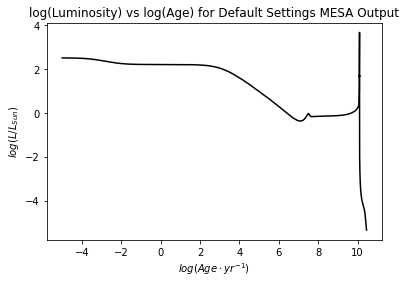

In [7]:
plt.plot(age, L, c='black')

plt.title(r'log(Luminosity) vs log(Age) for Default Settings MESA Output')
plt.xlabel(r'$log(Age \cdot yr^{-1})$')
plt.ylabel(r'$log(L/L_{Sun})$')

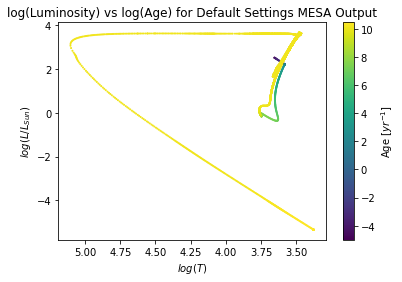

In [8]:
plt.scatter(T, L, s=1, c=age, cmap='viridis')
plt.gca().invert_xaxis()

plt.title(r'log(Luminosity) vs log(Age) for Default Settings MESA Output')
plt.xlabel(r'$log(T)$')
plt.ylabel(r'$log(L/L_{Sun})$')
plt.colorbar(label=r'Age $[yr^{-1}]$')

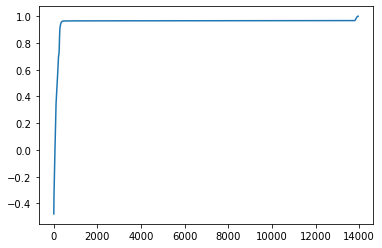

In [9]:
plt.plot(age/np.max(age))

## Problem 1

One input parameter I had an idea of what it might be but not an exact knowledge of is the "RGB Wind Scaling Factor". I assumed this would have something to do with stellar wind of stars on the red giant branch, but I wasn't sure why this parameter would be used and what exactly about the wind it specified. After looking at the MESA website which explains the parameters (http://user.astro.wisc.edu/~townsend/static.php?ref=mesa-web-input), this is a factor which scales the mass loss rate from wind of stars on the red giant branch. To be exact, this number is multiplied into the mass loss rate derived from a 'prescription' which models the stellar winds. The 'Red Giant Branch Wind Prescription' parameter allows you the specify which model to use, and they are derived from a variety of works in the literature which model winds from RGB stars.


I misread the prompt at first and thought it was asking for an output parameter, not an input. I just kept my writing on that below since I didn't want to waste that work.

One parameter I didn't know the interpretation of is the compactness parameter $\xi$. After reading through some papers (https://iopscience.iop.org/article/10.1088/0004-637X/730/2/70/pdf, https://iopscience.iop.org/article/10.1088/0004-637X/783/1/10, https://arxiv.org/abs/1807.09071, etc.) it seems like there may be a few cases where this parameter is used, but in general they all have the same definition. The 'compactness' of an object is the ratio of its mass to its radius. In the first paper labelled, they define the compactness parameter in the context of a star that's beginning to collapse. Specifically, they argue that the compactness parameter at the time when the infalling material of a collapsing star 'bounces' off the core determines whether or not a supernova will occur. The same case is taken in the second paper, while the third only looks at the compactness of stellar remnants (specifically neutron stars). 

## Problem 2

In [68]:
P_central = data_dict['log_center_P'] * (u.dyne/u.cm**2) # Simulated central pressure

star_mass = data_dict['star_mass'] * u.Msun
R = 10**data_dict['log_R'] * u.Rsun
Volume = 4/3 * np.pi * R**3
rho = star_mass / Volume # Average density of the whole star

P_analytic = c.G * star_mass * rho / R # Estimate for central pressure from example 10.1.1
P_analytic = P_analytic.to(u.dyne/u.cm**2) # Analytic pressure estimate

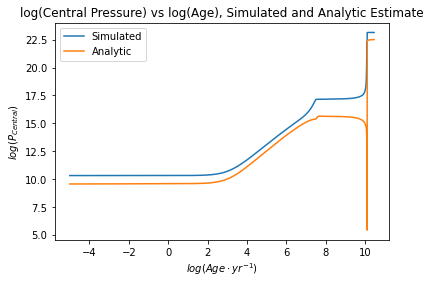

In [83]:
plt.plot(age, P_central, label='Simulated')
plt.plot(age, np.log10(P_analytic.value), label='Analytic')

plt.title(r'log(Central Pressure) vs log(Age), Simulated and Analytic Estimate')
plt.xlabel(r'$log(Age \cdot yr^{-1})$')
plt.ylabel(r'$log(P_{Central})$')
plt.legend();

The approximation seems to be best before ~6 Gyr. My guess is that in between these periods

In [223]:
rho_center = 10**data_dict['log_center_Rho'] * u.g/u.cm**3

lum_total = 10**data_dict['log_L'] * u.Lsun
lum_pp = 10**data_dict['pp'] * u.Lsun
lum_CNO = 10**data_dict['cno'] * u.Lsun

In [224]:
eps_0_pp = 1.08e-12 * u.W*u.m**3/u.kg**2
X = H_frac = data_dict['center_h1']
f_pp = 1 # Assume screening factor of ~1
psi_pp = 1 # Assume branch ratio of ~1
C_pp = 1 # Ignore higher order correction terms
eps_pp = lambda x: eps_0_pp*rho_center*X**2*f_pp*psi_pp*C_pp*x**4

In [225]:
eps_0_CNO = 8.24e-31 * u.W*u.m**3/u.kg**2
X_CNO = data_dict['center_c12'] + data_dict['center_n14'] + data_dict['center_o16']
eps_CNO = lambda x: eps_0_CNO*rho_center*X*X_CNO*x**19.9

In [226]:
# Estimating the total amount of mass of the star that's actually available for 
# fusion based on numbers from previous homeworks.
fusing_fraction = 0.1
fusing_mass = star_mass * fusing_fraction # * H_frac 

In [227]:
T_center = 10**data_dict['log_center_T']
T_6 = T_center / 1e6
lum_pp_power_law = eps_pp(T_6) * fusing_mass
lum_pp_power_law = lum_pp_power_law.to(u.Lsun)
lum_CNO_power_law = eps_CNO(T_6) * fusing_mass
lum_CNO_power_law = lum_CNO_power_law.to(u.Lsun)

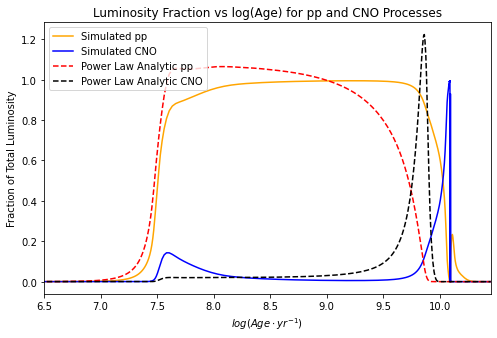

In [228]:
plt.figure(figsize=(8, 5))
plt.plot(age, lum_pp/lum_total, c='orange', label='Simulated pp')
plt.plot(age, lum_CNO/lum_total, c='blue', label='Simulated CNO')
plt.plot(age, lum_pp_power_law/lum_total, c='red', ls='--', label='Power Law Analytic pp')
plt.plot(age, lum_CNO_power_law/lum_total, c='black', ls='--', label='Power Law Analytic CNO')

plt.title(r'Luminosity Fraction vs log(Age) for pp and CNO Processes')
plt.xlim(6.5, 10.45175546)
plt.xlabel(r'$log(Age \cdot yr^{-1})$')
plt.ylabel(r'Fraction of Total Luminosity')
plt.legend(loc='upper left');

## Problem 3

In [357]:
profile_fname = 'mesa/MESA-Web_Job_09112317926/profile30.data'
profile_dict = mesa_web.read_profile(profile_fname)

In [358]:
profile_dict.keys()

dict_keys(['model_number', 'num_zones', 'initial_mass', 'initial_z', 'star_age', 'time_step', 'Teff', 'photosphere_L', 'photosphere_r', 'center_eta', 'center_h1', 'center_he3', 'center_he4', 'center_c12', 'center_n14', 'center_o16', 'center_ne20', 'star_mass', 'star_mdot', 'star_mass_h1', 'star_mass_he3', 'star_mass_he4', 'star_mass_c12', 'star_mass_n14', 'star_mass_o16', 'star_mass_ne20', 'he_core_mass', 'c_core_mass', 'o_core_mass', 'si_core_mass', 'fe_core_mass', 'neutron_rich_core_mass', 'tau10_mass', 'tau10_radius', 'tau100_mass', 'tau100_radius', 'dynamic_time', 'kh_timescale', 'nuc_timescale', 'power_nuc_burn', 'power_h_burn', 'power_he_burn', 'power_neu', 'burn_min1', 'burn_min2', 'time_seconds', 'version_number', 'compiler', 'build', 'MESA_SDK_version', 'math_backend', 'date', 'mass', 'radius', 'luminosity', 'pressure', 'logRho', 'logT', 'energy', 'entropy', 'cp', 'gamma1', 'grada', 'mu', 'free_e', 'ye', 'pgas', 'prad', 'gradr', 'gradT', 'velocity', 'conv_vel', 'opacity', 'eps

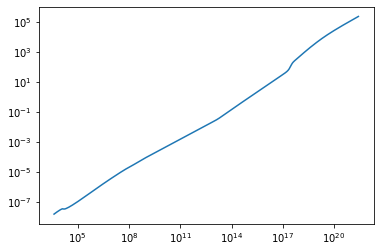

In [368]:
P = profile_dict['pressure'] * u.dyne/u.cm**2
rho = 10**profile_dict['logRho'] * u.g/u.cm**3
plt.loglog(P, rho)

In [359]:
density = 10**profile_dict['logRho'] * u.g/u.cm**3
radius = 10**profile_dict['radius'] * u.Rsun
mass = profile_dict['mass'] * u.Msun

dM = np.diff(mass)
dr = np.diff(radius)
# drho = np.average((density[:-1], density[1:]), axis=0) * u.g/u.cm**3
drho = density[:-1]
# drho
RHS = (drho*dr**3).to(u.Msun)

In [360]:
dM

<Quantity [7.81302165e-08, 1.56260434e-07, 3.12520867e-07, 6.25041734e-07,
           1.25008347e-06, 2.50016693e-06, 5.00033387e-06, 7.19846984e-06,
           7.19846984e-06, 1.43969397e-05, 2.87938794e-05, 5.75877587e-05,
           1.15175517e-04, 2.30351035e-04, 3.82312365e-04, 8.62471422e-04,
           1.59926972e-03, 2.62955997e-03, 5.79681800e-03, 5.49060217e-03,
           2.69405163e-03, 4.49008605e-03, 5.63102027e-03, 4.70669503e-03,
           7.38299636e-03, 7.72531247e-03, 3.32894418e-03, 6.05159727e-03,
           6.24669207e-03, 4.94167163e-03, 2.84180129e-03, 2.86613582e-03,
           5.09405555e-03, 5.15575128e-03, 3.71835003e-03, 7.51776374e-03,
           4.17840382e-03, 4.97346793e-03, 4.04921418e-03, 5.62808933e-03,
           5.47353505e-03, 3.93299617e-03, 4.33444575e-03, 5.15749554e-03,
           2.58449240e-03, 3.94312830e-03, 6.46129950e-03, 4.42514779e-03,
           3.52620542e-03, 2.32481338e-03, 5.26130599e-03, 4.05829077e-03,
           2.58982762e-03

In [361]:
RHS.shape

(796,)

In [362]:
help(mesa_web.read_profile)

Help on function read_profile in module mesa_web:

read_profile(filename, as_table=False)
    Read data from a MESA-Web profile file
    
    Parameters
    ----------
    
    filename -- string giving name of profile file
    as_table -- boolean flag indicating the format of the data returned: 
                    True: return as astropy.table.Table object
                    False: return as Python dict (default)
    
    Returns
    -------
    
    prof_data -- dict or Table containing header and profile data (see below for
                 details)
    
    Header Data
    -----------
    
    The following keys/value pairs in the returned dict (or Table.meta dict) 
    contain header data -- i.e., scalars describing position-independent 
    properties of the star. Where applicable, units are given in square 
    brackets [].
    
      star_mdot              -- mass-loss rate [Msun/year]
      model_number           -- model number
      num_zones              -- number of zone

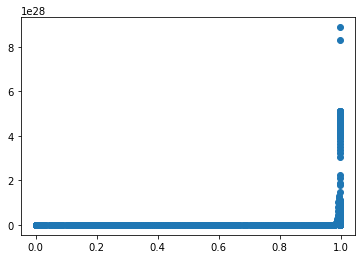

In [363]:
plt.scatter(mass[:-1], RHS)
# plt.ylim(-1, 1)

In [297]:
start_num = 10
end_num = 300
step = 10
density_list = np.zeros(len(range(start_num, end_num, step)))
radius_list = np.zeros(len(range(start_num, end_num, step)))
mass_list = np.zeros(len(range(start_num, end_num, step)))
index_list = np.zeros(len(range(start_num, end_num, step)))
for i, index in enumerate(range(start_num, end_num, step)):
    profile_fname = f'mesa/MESA-Web_Job_09112317926/profile{index}.data'
    profile_dict = mesa_web.read_profile(profile_fname)
    density = 10**profile_dict['logRho'][0]
    radius = 10**profile_dict['radius'][-1]
    mass = profile_dict['star_mass']
    density_list[i-1] = density
    radius_list[i-1] = radius
    mass_list[i-1] = mass
    index_list[i-1] = index

In [298]:
density_list = density_list * u.g/u.cm**3
radius_list = radius_list * u.Rsun
mass_list = mass_list * u.Msun

(2, 5)


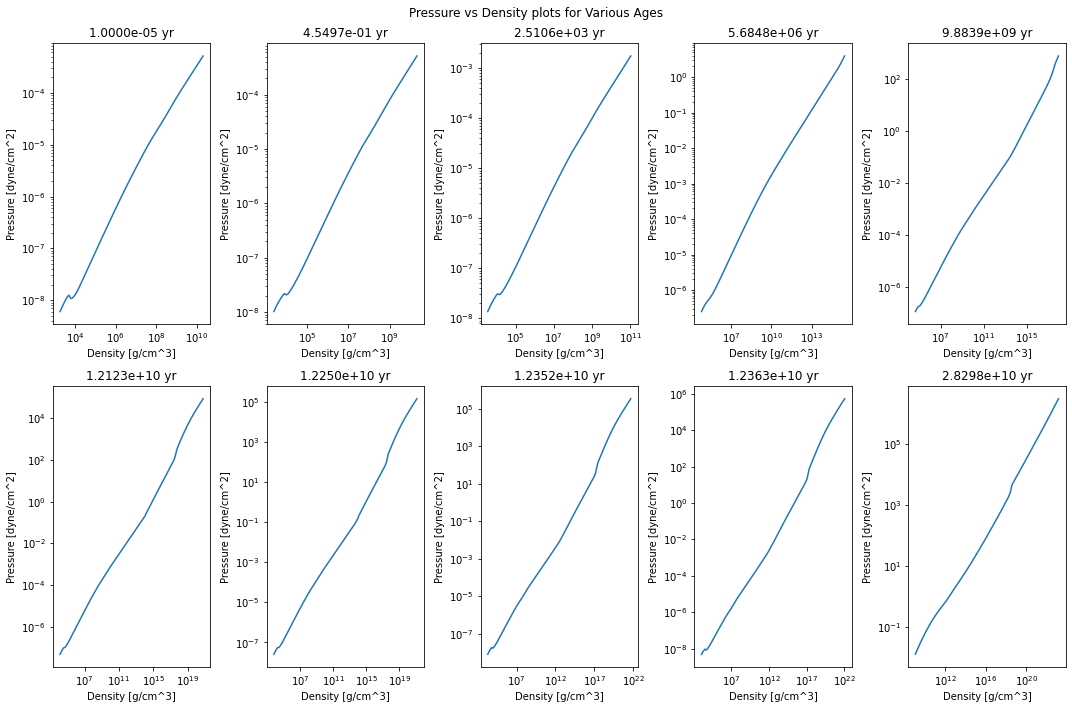

In [399]:
frames = np.array([1, 2, 3, 5, 10, 15, 20, 50, 100, 300]).reshape(2, 5)


plot_nums = frames.shape
print(plot_nums)

fig, ax = plt.subplots(*plot_nums, figsize=(15, 10))

for i, index in enumerate(frames.flatten()):
    profile_fname = f'mesa/MESA-Web_Job_09112317926/profile{index}.data'
    profile_dict = mesa_web.read_profile(profile_fname)
    
    P = profile_dict['pressure']
    rho = 10**profile_dict['logRho']
    age = profile_dict['star_age']
    
    ax[i // 5, i % 5].loglog(P, rho)
    ax[i // 5, i % 5].set_title(f'{age:.4e} yr')
    ax[i // 5, i % 5].set_xlabel('Density [g/cm^3]')
    ax[i // 5, i % 5].set_ylabel('Pressure [dyne/cm^2]')

plt.suptitle('Pressure vs Density plots for Various Ages')
plt.tight_layout()

Since this is a loglog plot of pressure against density, from the polytrope equation we should expect that a polytropic model would be a straight line on this plot. Indeed, most of these profiles very closely seem to follow straight lines, which means that the stellar model is fairly close to a polytrope at a variety of time and length scales.

In [400]:
grad_adiabatic = profile_dict['grada']
grad_radiative = profile_dict['gradr']
grad_physical = profile_dict['gradT']